# Car Base Regression

On this project, we will use the "auto" dataset. This file have some informations about car sales, including informations about the car, the seller and price. The idea of this project is to predict the price of a car, based on some input informations as the brand, fuel type and age of the vehicle.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from  torch import nn, optim
import torch.nn.functional as F

In [3]:
np.random.seed(123)
torch.manual_seed(123)

In [4]:
base = pd.read_csv('../../Bases/autos.csv', encoding='ISO-8859-1')

In [5]:
base.head()

dateCrawled                            name  seller offerType  \
0  2016-03-24 11:52:17                      Golf_3_1.6  privat   Angebot   
1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   Angebot   
2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   Angebot   
3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   Angebot   
4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   

   price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test         NaN                1993    manuell        0   golf   
1  18300   test       coupe                2011    manuell      190    NaN   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  nrOfPictures  postalCode             lastSeen  
0  2016-03-24 00:00:00             0       70435  2016-04-07 03:16:57  
1  2016-03-24 00:00:00             0       66954  2016-04-07 01:46:50  
2  2016-03-14 00:00:00             0       90480  2016-04-05 12:47:46  
3  2016-03-17 00:00:00             0       91074  2016-03-17 17:40:17  
4  2016-03-31 00:00:00             0       60437  2016-04-06 10:17:21

Here, we have a lot of features inside our dataset. This may cause the training step to be really slow, so, in order to avoid this the best way we can, we may exclude some features we see that are not important to our model's prediction, as the **postalcode**, the **nrOfPictures**, and so on...

In [6]:
base = base.drop('dateCrawled', axis=1)
base = base.drop('dateCreated', axis=1)
base = base.drop('nrOfPictures', axis=1)
base = base.drop('postalCode', axis=1)
base = base.drop('lastSeen', axis=1)

In [7]:
base.shape

(371528, 15)

The name of the vehicle may have names that doesn\`t necessarely give some information about the car value. Let\`s make a quick analise on this feature in order to understand it:

In [8]:
base['name'].value_counts()

Ford_Fiesta                                                       657
BMW_318i                                                          627
Opel_Corsa                                                        622
Volkswagen_Golf_1.4                                               603
BMW_316i                                                          523
                                                                 ... 
Vw_Golf_4_1_4_16v_TÜV_neu                                           1
BMW_325i__Automatik                                                 1
Ford_Fiesta_1.3l_JBS_Bastler_Ausschlachten                          1
Mercedes_Benz_C_200_T_Kompr._Avantgarde_Klimaauto__Leder__Navi      1
Astra_G__BEAST__Show_Car                                            1
Name: name, Length: 233531, dtype: int64

By the "Name" feature values, we see it has some values information about the car brand and the model, but we have too, some values that doesn\`t mean anything for our project and will possibly make our algorithm less accurate. In terms of brand and model, this feature can be easily replaced by "vehicleType" and "brand". So, we will drop this feature from our model.

In [9]:
base = base.drop('name', axis=1)

In [10]:
base['seller'].value_counts()

privat        371525
gewerblich         3
Name: seller, dtype: int64

On Seller counts, we see that almost every line on our data has a "privat" seller value, only 3 are from the other class. This unbaleced class won\`t give us a valueble information, so we will drop it too:  

In [11]:
base = base.drop('seller', axis=1)

In [12]:
base['offerType'].value_counts()

Angebot    371516
Gesuch         12
Name: offerType, dtype: int64

The same thing happens with the "offerType" feature. So, we will dropp it from our model:

In [13]:
base = base.drop('offerType', axis = 1)

Let\`s see how our data is presented now:

In [14]:
base.shape

(371528, 12)

In [15]:
base.head()

price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test         NaN                1993    manuell        0   golf   
1  18300   test       coupe                2011    manuell      190    NaN   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  
0     150000                    0   benzin  volkswagen               NaN  
1     125000                    5   diesel        audi                ja  
2     125000                    8   diesel        jeep               NaN  
3     150000                    6   benzin  volkswagen              nein  
4      90000                    7   diesel       skoda              nein

Let\`s analyse the distribution from our main data we want to predict, in order to know if we need to threat some kind of outlier. Let\`s analyse the price value from our dataset:

In [16]:
base['price'].describe()

count    3.715280e+05
mean     1.729514e+04
std      3.587954e+06
min      0.000000e+00
25%      1.150000e+03
50%      2.950000e+03
75%      7.200000e+03
max      2.147484e+09
Name: price, dtype: float64

By the "describe()" method, we can see that we have a maximum and minimum value really far from the percentiles used by default on the method. In order to visualize it with a deep understanding of our feature, we may use more percentiles to understand the distribution from the data farther from the mean value, and plot it\`s boxplot:

In [17]:
base['price'].describe(percentiles=[.01, .02, .03, .04, .05, .10, .25, .50, .75, .90, .95, .98, .99])

count    3.715280e+05
mean     1.729514e+04
std      3.587954e+06
min      0.000000e+00
1%       0.000000e+00
2%       0.000000e+00
3%       1.000000e+00
4%       1.400000e+02
5%       2.000000e+02
10%      5.000000e+02
25%      1.150000e+03
50%      2.950000e+03
75%      7.200000e+03
90%      1.400000e+04
95%      1.979000e+04
98%      2.800000e+04
99%      3.600000e+04
max      2.147484e+09
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

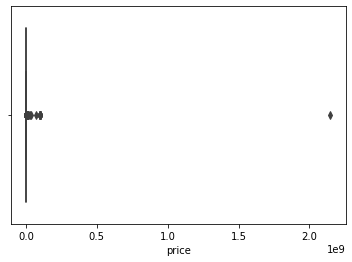

In [18]:
sns.boxplot(base['price'])

Here we see how the data behavior on each percentile. The values of percentile are breake by 1% untill 5%, so we can see how the real low values are distributed on our dataset. By firs\`t impression, we may tell that we have some outliers observations below 3% and above 99% of our data. Any value in the middle of this two numbers may be a coherent value for the price feature.

The boxplot plotted with seaborn shows that we have such high outliers, that we can\`t even see the boxes created between the 25% and 75% of our price data. This tells us that, before moving further, **we must clean this price feature**, in order to present to our model, real consistant information about price car.

## Threating Outliers from price feature:

As a method of treating the outliers from price feature, we will make a test on dropping the lines using the IQR score method and see how the output data is received from this technique: 

In [19]:
Q1 = base['price'].quantile(0.25)
Q3 = base['price'].quantile(0.75)

IQR = Q3-Q1

base_clean = base[~((base['price'] < (Q1-1.5*IQR)) | (base['price'] > (Q3 + 1.5*IQR)))]

In [20]:
print('number of observations dropped from the dataset:\t %d (%.2f%%)' % (base.shape[0] - base_clean.shape[0], (base.shape[0] - base_clean.shape[0])/base.shape[0]*100))

number of observations dropped from the dataset:	 28108 (7.57%)


In [21]:
base_clean['price'].describe(percentiles=[.01, .02, .03, .04, .05, .10, .25, .50, .75, .90, .95, .98, .99])

count    343420.000000
mean       3980.284025
std        3851.319988
min           0.000000
1%            0.000000
2%            0.000000
3%            0.000000
4%          100.000000
5%          190.000000
10%         450.000000
25%        1000.000000
50%        2550.000000
75%        5900.000000
90%        9990.000000
95%       12500.000000
98%       14500.000000
99%       15400.000000
max       16270.000000
Name: price, dtype: float64

<AxesSubplot:xlabel='price'>

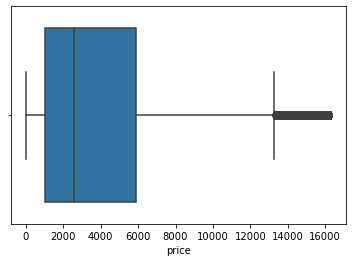

In [22]:
sns.boxplot(base_clean['price'])

As we see from our "Describe()" method\`s output and the final boxplot, the IQR method dropped 28.108 lines of data, and it seems it dropped values above the 95% percentile and didn\`t dropped the lower prices outliers. So, instead of using IQR for the datacleaning, we will set the lower and higher values based on what the describe method brought as an output. 

In order of get a clean dataset and drop every line we consider an outlier, what we will do is to drop every line below 5% and above 98%. Based on the "Descibe()" method from the base dataset, every line between these two limits can be seen as a coherent data for a car price. 

### Now we have a cleaner data, let\`s analyse the null data in our current dataset:

In [23]:
# for each column, count null values an null values divided by number of observations
print('null analyses:\n')
for list in base_clean.columns:
    print('%s \t %d(%.2f%%)' % (list, base_clean[list].isnull().sum(), (base_clean[list].isnull().sum()/base_clean[list].shape[0])*100))

null analyses:

price 	 0(0.00%)
abtest 	 0(0.00%)
vehicleType 	 37177(10.83%)
yearOfRegistration 	 0(0.00%)
gearbox 	 19683(5.73%)
powerPS 	 0(0.00%)
model 	 19344(5.63%)
kilometer 	 0(0.00%)
monthOfRegistration 	 0(0.00%)
fuelType 	 32585(9.49%)
brand 	 0(0.00%)
notRepairedDamage 	 70429(20.51%)


As seen in our previous output, not all columns have null observations, so, we doesn\`t need to apply null analyses on every column, just on vehicleType / gearbox / model / fuelType / notRepairedDamage.

In null analyses, the first thing to do is find the features that has null values, and then, apply some action uppon this values lines, like: 
* Drop the lines with null values;
* Replace the null data with some value (mean value from the observations of that feature / the most shown value of the feature... etc.)

Let's see the lines with null values on "**vehicletype**"

In [24]:
base_clean.loc[pd.isnull(base_clean['vehicleType'])]

price   abtest vehicleType  yearOfRegistration    gearbox  powerPS  \
0         480     test         NaN                1993    manuell        0   
16        300     test         NaN                2016        NaN       60   
22       2900     test         NaN                2018    manuell       90   
26       5555  control         NaN                2017    manuell      125   
31        899  control         NaN                2016    manuell       60   
...       ...      ...         ...                 ...        ...      ...   
371504   2600  control         NaN                2005  automatik        0   
371509   1900     test         NaN                2000    manuell      110   
371519   5250  control         NaN                2016  automatik      150   
371522      0  control         NaN                2005    manuell        0   
371523   2200     test         NaN                2005        NaN        0   

           model  kilometer  monthOfRegistration fuelType           brand  \
0           golf     150000                    0   benzin      volkswagen   
16          polo     150000                    0   benzin      volkswagen   
22        meriva     150000                    5   benzin            opel   
26            c4     125000                    4      NaN         citroen   
31          clio     150000                    6   benzin         renault   
...          ...        ...                  ...      ...             ...   
371504  c_klasse     150000                    9      NaN   mercedes_benz   
371509       NaN     150000                    7      NaN      volkswagen   
371519       159     150000                   12      NaN      alfa_romeo   
371522      colt     150000                    7   benzin      mitsubishi   
371523       NaN      20000                    1      NaN  sonstige_autos   

       notRepairedDamage  
0                    NaN  
16                   NaN  
22                  nein  
26                  nein  
31                   NaN  
...                  ...  
371504               NaN  
371509              nein  
371519              nein  
371522                ja  
371523               NaN  

[37177 rows x 12 columns]

As for these feature, we have 31.343 rows of data, we can\`t just drop all these lines. So the option we will adopte is to replace the null values with the most shown value of these feature.

The right thing to do on these case, is to return to the client and understand if this is a problem on the extraction of the dataset, or a problem on the database on itself, and align the right understand of these data. As these project's idea is to practice data analysis and machine learning knowledge, we will set these null values as the most shown on our data. 

In [25]:
base_clean['vehicleType'].value_counts() # Most show value: limousine

limousine     88490
kleinwagen    79469
kombi         63115
bus           27742
cabrio        18806
coupe         14901
suv           10490
andere         3230
Name: vehicleType, dtype: int64

In [26]:
base_clean['gearbox'].value_counts() # Most show value: manuell

manuell      262587
automatik     61150
Name: gearbox, dtype: int64

In [27]:
base_clean['model'].value_counts() # Most show value: golf

golf                  28406
andere                23528
3er                   19111
polo                  13028
corsa                 12564
                      ...  
gl                        3
rangerover                3
serie_3                   3
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

In [28]:
base_clean['fuelType'].value_counts() # Most show value: benzin

benzin     211652
diesel      92880
lpg          5246
cng           563
hybrid        207
andere        202
elektro        85
Name: fuelType, dtype: int64

In [29]:
base_clean['notRepairedDamage'].value_counts() # Most show value: nein

nein    237092
ja       35899
Name: notRepairedDamage, dtype: int64

Let\`s replace the null features by values we saw before:

In [30]:
values = {'vehicleType': 'limousine', 'gearbox': 'manuell', 'model': 'golf', 'fuelType': 'benzin', 'notRepairedDamage': 'nein'}

In [31]:
base_clean = base_clean.fillna(value=values)

In [32]:
base_clean.isnull().sum() # If the cleaning step was made correctly, the output of these method must be zero.

price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64

Now we cleaned the data, it\`s time to separate it in order used it on our machine learning model.

In [33]:
features = base_clean.iloc[:, 1:].values
classes = base_clean.iloc[:, 0].values

In [34]:
features[0:5]

array([['test', 'limousine', 1993, 'manuell', 0, 'golf', 150000, 0,
        'benzin', 'volkswagen', 'nein'],
       ['test', 'suv', 2004, 'automatik', 163, 'grand', 125000, 8,
        'diesel', 'jeep', 'nein'],
       ['test', 'kleinwagen', 2001, 'manuell', 75, 'golf', 150000, 6,
        'benzin', 'volkswagen', 'nein'],
       ['test', 'kleinwagen', 2008, 'manuell', 69, 'fabia', 90000, 7,
        'diesel', 'skoda', 'nein'],
       ['test', 'limousine', 1995, 'manuell', 102, '3er', 150000, 10,
        'benzin', 'bmw', 'ja']], dtype=object)

In [35]:
base_clean.head()

price abtest vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480   test   limousine                1993    manuell        0   golf   
2   9800   test         suv                2004  automatik      163  grand   
3   1500   test  kleinwagen                2001    manuell       75   golf   
4   3600   test  kleinwagen                2008    manuell       69  fabia   
5    650   test   limousine                1995    manuell      102    3er   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  
0     150000                    0   benzin  volkswagen              nein  
2     125000                    8   diesel        jeep              nein  
3     150000                    6   benzin  volkswagen              nein  
4      90000                    7   diesel       skoda              nein  
5     150000                   10   benzin         bmw                ja

### Categoric Data:

As we see by our output since the begining, we have categoricall data, meaning, that this values are not numeric, but text (Strings that represents a class). In this case, we must apply the oneHot Encoding technique, that will create a column for each value inside each categoric column. This way, creating a binary statement (Or a flag) that will show to our model when, for that specific feature, we have the class a, b or c:

Example: for "gearbox" feature: 

| manuell | automatik|

|0 |1 |

|1 |0 |

In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [37]:
oneHotEncoder = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [0,1,3,5,8,9,10])], remainder='passthrough') # Setting the type of transformation of the columns, the columns that will be transformed, and the passthrough statement, remainding to keep all columns.

In [38]:
features_OHE = oneHotEncoder.fit_transform(features).toarray()

In [39]:
print('features shape: \t %s \nclasses shape: \t %s' %(features_OHE.shape, classes.shape))

features shape: 	 (343420, 315) 
classes shape: 	 (343420,)


In [40]:
features_OHE = torch.tensor(features_OHE, dtype=torch.float)
classes = torch.tensor(classes, dtype=torch.float).view(-1,1)

In [41]:
print('features shape: \t %s \nclasses shape: \t %s' %(features_OHE.shape, classes.shape))

features shape: 	 torch.Size([343420, 315]) 
classes shape: 	 torch.Size([343420, 1])


## Creating the Model

Important steps in order to create and train the model:

* Determine the neural network structure;
* Create the model(Input layer, hiden layers and output layer with each activation function);
* Determine the parameters to be used on the neural network training step;
* Create the dataloader instance to feed the neural network;

In [42]:
# Model Structure: 315 -> 158 -> 158 -> 1
# Hidden Layer:    (Input + Output)/2 = 158

#Creating a neural network model with 2 hidden layers and RELU as the activation function for the layers

model_nn = nn.Sequential(nn.Linear(315, 158),
                        nn.ReLU(),
                        nn.Linear(158, 158),
                        nn.ReLU(),
                        nn.Linear(158, 1))


In [43]:
# Determining the loss criterion and the optimization method to be used for our model:

criterion = nn.L1Loss() # this method uses the Mean Absolute Error (MAE) to calculate the loss from our model on each step;

optim = optim.Adam(model_nn.parameters()) # it will use Adam optimization method in order to optimize our models parameters;

In [44]:
dataset = torch.utils.data.TensorDataset(features_OHE, classes)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=300, shuffle=True)

## Training our model:

Let\`s check if our torch is able of using our GPU in order to trian our model:

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [46]:
model_nn.to(device)

Sequential(
  (0): Linear(in_features=315, out_features=158, bias=True)
  (1): ReLU()
  (2): Linear(in_features=158, out_features=158, bias=True)
  (3): ReLU()
  (4): Linear(in_features=158, out_features=1, bias=True)
)

In [47]:
for n, p in model_nn.named_parameters():
    print(p.device, '', n)

cuda:0  0.weight
cuda:0  0.bias
cuda:0  2.weight
cuda:0  2.bias
cuda:0  4.weight
cuda:0  4.bias


In [48]:
for epoch in range(200):  # Here, we will use 300 epochs to train our model
    # Creating the loss variable and the mean absolute error
    running_loss = 0.
    running_mae = 0.

    #Applying the training for each batch generated on our DataLoader:
    for i, data in enumerate(train_loader):

        features_, labels = data

        # passing the data tensors to our device (GPU):
        features_, labels = features_.to(device), labels.to(device)

        # Before each step from the training, it`s important to reset the grad
        optim.zero_grad()

        output = model_nn.forward(features_)

        # Here, we will calculate the l1.loss(MAE) to keep tracking of the loss value.
        mae = F.l1_loss(output, labels).item()
        running_mae += mae

        # This next l1.loss method, will be used directly by the model:
        loss = criterion(output, labels)
        loss.backward() # Calculates the gradient of our model

        optim.step() # Update the weights from our model

        running_loss += loss.item()

        print('\nEpoch: %d - Step %d from %d: loss %.2f - MAE %.2f' % (epoch+1, i+1, len(classes)//300, loss, mae))

        del features_
        del labels
        torch.cuda.empty_cache()

    print('\nEpoch: %d ENDED: Mean Loss: %.5f - MAE %.5f' % (epoch+1, running_loss/len(train_loader),running_mae/len(train_loader)))




144: loss 1558.59 - MAE 1558.59

Epoch: 200 - Step 822 from 1144: loss 1541.90 - MAE 1541.90

Epoch: 200 - Step 823 from 1144: loss 1605.44 - MAE 1605.44

Epoch: 200 - Step 824 from 1144: loss 1579.78 - MAE 1579.78

Epoch: 200 - Step 825 from 1144: loss 1428.35 - MAE 1428.35

Epoch: 200 - Step 826 from 1144: loss 1530.75 - MAE 1530.75

Epoch: 200 - Step 827 from 1144: loss 1479.39 - MAE 1479.39

Epoch: 200 - Step 828 from 1144: loss 1553.86 - MAE 1553.86

Epoch: 200 - Step 829 from 1144: loss 1525.21 - MAE 1525.21

Epoch: 200 - Step 830 from 1144: loss 1382.11 - MAE 1382.11

Epoch: 200 - Step 831 from 1144: loss 1568.41 - MAE 1568.41

Epoch: 200 - Step 832 from 1144: loss 1432.72 - MAE 1432.72

Epoch: 200 - Step 833 from 1144: loss 1515.34 - MAE 1515.34

Epoch: 200 - Step 834 from 1144: loss 1657.33 - MAE 1657.33

Epoch: 200 - Step 835 from 1144: loss 1607.84 - MAE 1607.84

Epoch: 200 - Step 836 from 1144: loss 1625.59 - MAE 1625.59

Epoch: 200 - Step 837 from 1144: loss 1639.78 - MAE 

## Model Evaluation:

In [49]:
model_nn.eval()

Sequential(
  (0): Linear(in_features=315, out_features=158, bias=True)
  (1): ReLU()
  (2): Linear(in_features=158, out_features=158, bias=True)
  (3): ReLU()
  (4): Linear(in_features=158, out_features=1, bias=True)
)

In [50]:
predictions = model_nn.forward(features_OHE.to(device))

In [51]:
predictions

tensor([[  626.2461],
        [10564.2119],
        [ 1229.2430],
        ...,
        [ 4458.2192],
        [ 5680.2632],
        [ 3121.7791]], device='cuda:0', grad_fn=<AddmmBackward>)

In [52]:
classes

tensor([[ 480.],
        [9800.],
        [1500.],
        ...,
        [1199.],
        [9200.],
        [3400.]])

In [53]:
model_variation = classes.mean() - predictions.mean()

In [54]:
abs(model_variation)

tensor(350.4075, device='cuda:0', grad_fn=<AbsBackward>)

The value showed above, represents the error that our model may have for the dataset used. So, our final model may present a USD$ 350,41 of error to the real prices.